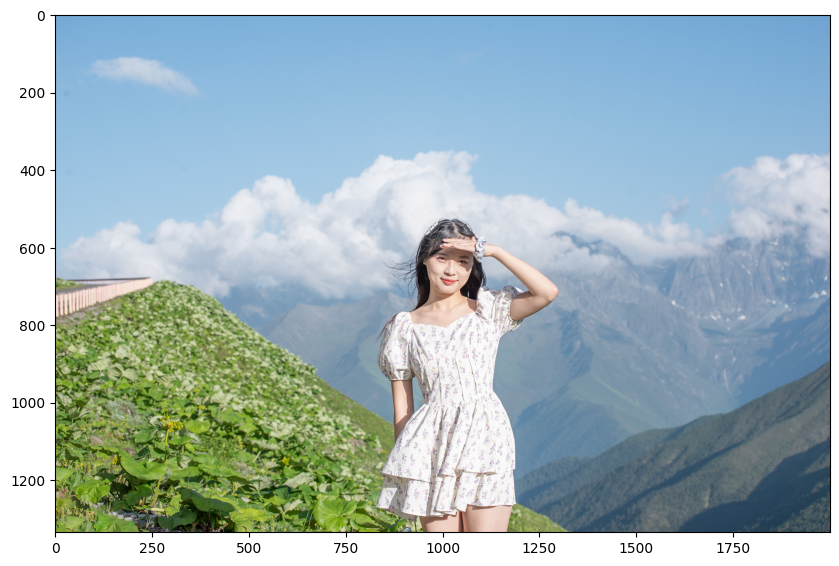

In [2]:
import sys
sys.path.append('../')
import cv2
import matplotlib.pyplot as plt
import numpy as np

img_file = './image_example/before_align.jpg'
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [3]:
import mtcnn
from mtcnn.utils import draw


# First we create pnet, rnet, onet, and load weights from caffe model.
pnet, rnet, onet = mtcnn.get_net_caffe('../output/converted')

# Then we create a detector
detector = mtcnn.FaceDetector(pnet, rnet, onet, device='cuda:0')

/home/fxf/anaconda3/envs/face_detection/lib/python3.8/site-packages/torch_mtcnn-0.1-py3.8-linux-x86_64.egg/mtcnn/network/mtcnn_pytorch.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/home/fxf/anaconda3/envs/face_detection/lib/python3.8/site-packages/torch_mtcnn-0.1-py3.8-linux-x86_64.egg/mtcnn/network/mtcnn_pytorch.py:10: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)


In [4]:
img = cv2.imread(img_file)
boxes, landmarks = detector.detect(img, minsize=24)
landmarks_np=landmarks.numpy()
face = draw.crop(img, boxes=boxes, landmarks=landmarks_np)[0]
face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

/home/fxf/anaconda3/envs/face_detection/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/fxf/anaconda3/envs/face_detection/lib/python3.8/site-packages/torch_mtcnn-0.1-py3.8-linux-x86_64.egg/mtcnn/deploy/detect.py:90: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  inds = (probs > threshold).nonzero()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

[38 51]
[73 51]
[56 71]
[41 92]
[70 92]


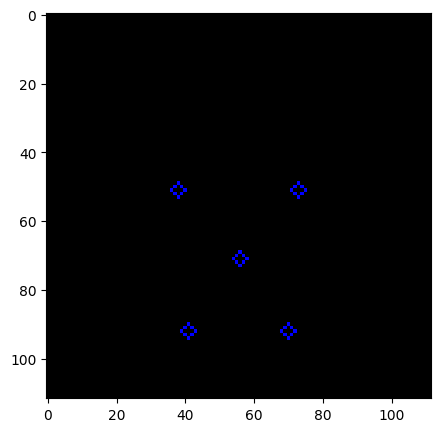

In [ ]:
# Define the correct points.
REFERENCE_FACIAL_POINTS = np.array([
    [38.29459953, 51.69630051],
    [73.53179932, 51.50139999],
    [56.02519989, 71.73660278],
    [41.54930115, 92.3655014 ],
    [70.72990036, 92.20410156]
], np.float32)

# Lets create a empty image|
empty_img = np.zeros((112,112,3), np.uint8) 
draw.draw_landmarks(empty_img, REFERENCE_FACIAL_POINTS.astype(int))

plt.figure(figsize=(5, 5))
plt.imshow(empty_img)
plt.show()

[1001  632]
[1051  640]
[1022  669]
[994 679]
[1039  688]


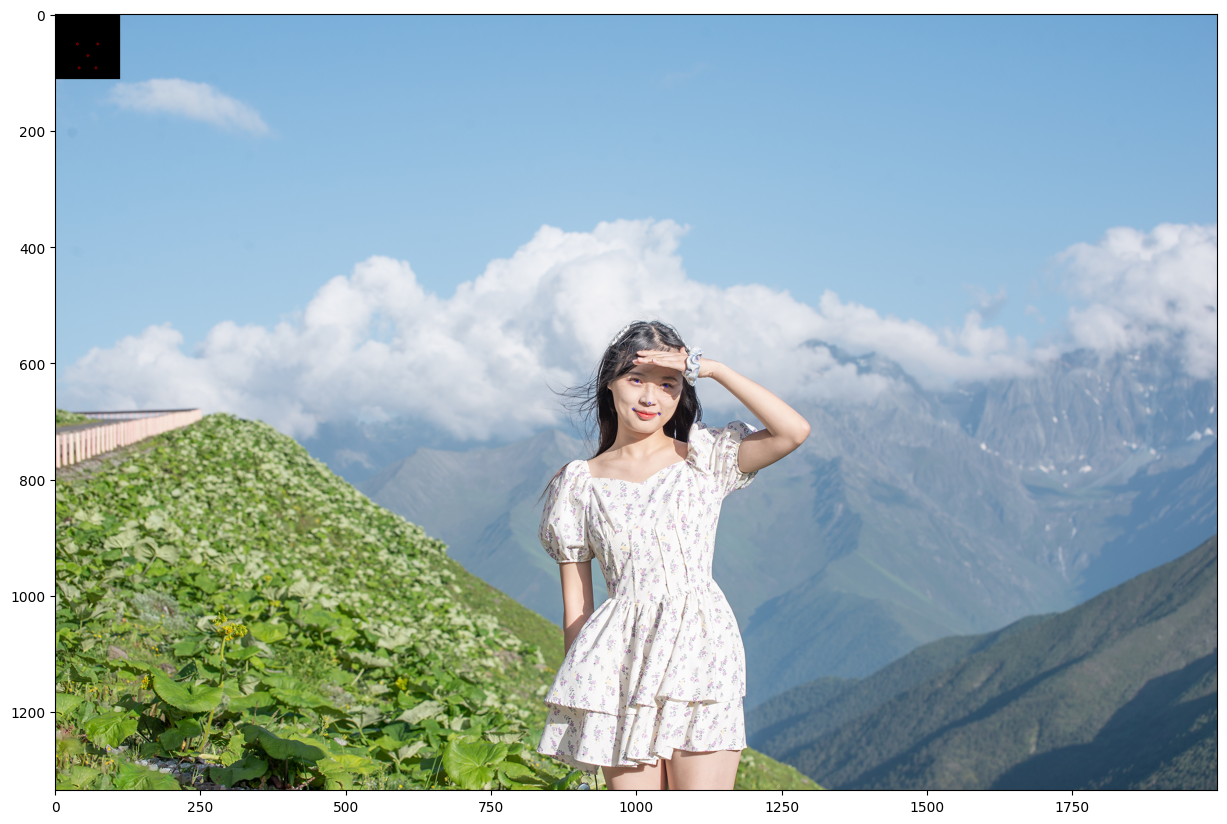

In [ ]:
img_copy = img.copy()
landmark_np = landmarks_np[0]
landmark=landmarks[0]
img_copy[:112, :112, :] = empty_img
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
draw.draw_landmarks(img_copy, landmark_np)

plt.figure(figsize=(15, 15))
plt.imshow(img_copy)
plt.show()

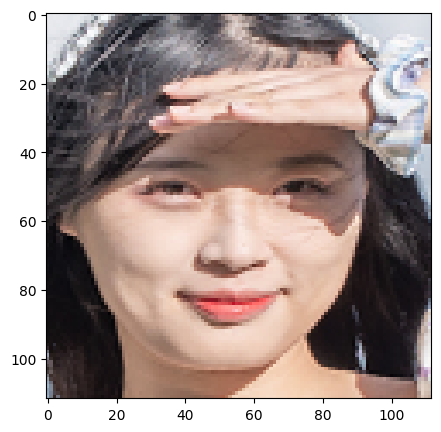

In [ ]:
trans_matrix = cv2.getAffineTransform(landmark[:3].cpu().numpy().astype(np.float32), REFERENCE_FACIAL_POINTS[:3])
aligned_face = cv2.warpAffine(img.copy(), trans_matrix, (112, 112))
aligned_face = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(aligned_face)
plt.show()

/tmp/ipykernel_2037891/3737476152.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)


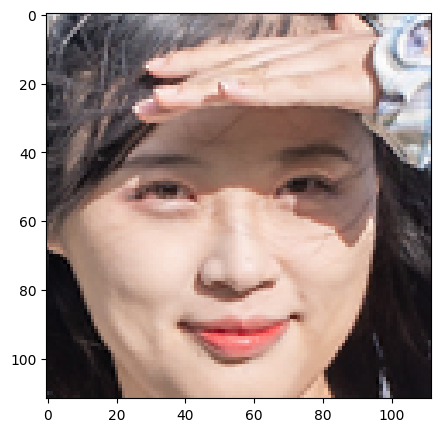

In [ ]:
from numpy.linalg import inv, norm, lstsq
from numpy.linalg import matrix_rank as rank

def findNonreflectiveSimilarity(uv, xy, K=2):

    M = xy.shape[0]
    x = xy[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    y = xy[:, 1].reshape((-1, 1))  # use reshape to keep a column vector

    tmp1 = np.hstack((x, y, np.ones((M, 1)), np.zeros((M, 1))))
    tmp2 = np.hstack((y, -x, np.zeros((M, 1)), np.ones((M, 1))))
    X = np.vstack((tmp1, tmp2))

    u = uv[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    v = uv[:, 1].reshape((-1, 1))  # use reshape to keep a column vector
    U = np.vstack((u, v))

    # We know that X * r = U
    if rank(X) >= 2 * K:
        r, _, _, _ = lstsq(X, U)
        r = np.squeeze(r)
    else:
        raise Exception('cp2tform:twoUniquePointsReq')

    sc = r[0]
    ss = r[1]
    tx = r[2]
    ty = r[3]

    Tinv = np.array([
        [sc, -ss, 0],
        [ss,  sc, 0],
        [tx,  ty, 1]
    ])


    T = inv(Tinv)

    T[:, 2] = np.array([0, 0, 1])

    T = T[:, 0:2].T

    return T

similar_trans_matrix = findNonreflectiveSimilarity(landmark.cpu().numpy().astype(np.float32), REFERENCE_FACIAL_POINTS)

aligned_face = cv2.warpAffine(img.copy(), similar_trans_matrix, (112, 112))
aligned_face = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(5, 5))
plt.imshow(aligned_face)
plt.show()